# Retrieve organic matter aerosol optical depth from the Atmosphere Data Store and visualise 2015 anomalies

<img src="https://ads.atmosphere.copernicus.eu/themes/custom/baby_blue/logo.svg" width=140> 
This notebook demonstrates how to retrieve NetCDF data from the Atmosphere Data Store (https://ads.atmosphere.copernicus.eu/) (ADS) and anomaly map using xarray and Cartopy libraries.

First, let's define some general purpose variables

In [1]:
DATADIR = '../../eodata/cams'
DATAFILE = 'cams_omaod_October.nc'
DOWNLOAD = True
years = [str(y) for y in range(2003, 2021)]

Next, we will retrieve the data from the ADS by using the cdsapi Python library. 

https://ads.atmosphere.copernicus.eu/api-how-to 

**To be able to run the data retrieval example below you will need to register on the Atmosphere Data Store (https://ads.atmosphere.copernicus.eu/) and then visit this page: https://ads.atmosphere.copernicus.eu/api-how-to to obtain the API authentication key.**

If you want to speed up the process, you can use the files which are already available on the LTPY training platform.

In [2]:
if DOWNLOAD:

    import cdsapi
    # to suppress SSL warnings
    import urllib3
    urllib3.disable_warnings()

    # enter your ADS authentication key
    URL = "https://ads.atmosphere.copernicus.eu/api/v2"
    KEY = "3512:52600066-3b0b-4213-bb5d-2d9b686b7fce"
    c = cdsapi.Client(url=URL, key=KEY)

    c.retrieve('cams-global-reanalysis-eac4-monthly', {
       'format': 'netcdf',
       'variable': 'organic_matter_aerosol_optical_depth_550nm',
       'year': years,
       'month': '10',
       'product_type': 'monthly_mean',
    }, f'{DATADIR}/{DATAFILE}')


2021-06-24 09:13:46,706 INFO Welcome to the CDS
2021-06-24 09:13:46,709 INFO Sending request to https://ads.atmosphere.copernicus.eu/api/v2/resources/cams-global-reanalysis-eac4-monthly
2021-06-24 09:13:46,908 INFO Request is completed
2021-06-24 09:13:46,909 INFO Downloading https://download-0000.copernicus-atmosphere.eu/cache-compute-0000/cache/data6/adaptor.mars.internal-1624482435.9995935-5830-10-fc604d5a-d4b6-434d-8667-8cd0151d7f31.nc to ../../eodata/cams/cams_omaod_October.nc (4M)
2021-06-24 09:13:47,488 INFO Download rate 6.9M/s   


Let's inspect one file

In [5]:
import xarray as xr
ds = xr.open_dataset(f'{DATADIR}/{DATAFILE}')
ds.time

<xarray.DataArray 'time' (time: 18)>
array(['2003-10-01T00:00:00.000000000', '2004-10-01T00:00:00.000000000',
       '2005-10-01T00:00:00.000000000', '2006-10-01T00:00:00.000000000',
       '2007-10-01T00:00:00.000000000', '2008-10-01T00:00:00.000000000',
       '2009-10-01T00:00:00.000000000', '2010-10-01T00:00:00.000000000',
       '2011-10-01T00:00:00.000000000', '2012-10-01T00:00:00.000000000',
       '2013-10-01T00:00:00.000000000', '2014-10-01T00:00:00.000000000',
       '2015-10-01T00:00:00.000000000', '2016-10-01T00:00:00.000000000',
       '2017-10-01T00:00:00.000000000', '2018-10-01T00:00:00.000000000',
       '2019-10-01T00:00:00.000000000', '2020-10-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2003-10-01 2004-10-01 ... 2020-10-01
Attributes:
    long_name:  time

Let's compute AOD550 December climatology based on 2003-2018 CAMS Reanalysis

In [ ]:
ds.latitude

In [ ]:
ds.time

In [6]:
ds.omaod550

<xarray.DataArray 'omaod550' (time: 18, latitude: 241, longitude: 480)>
[2082240 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 0.0 0.75 1.5 2.25 ... 357.75 358.5 359.25
  * latitude   (latitude) float32 90.0 89.25 88.5 87.75 ... -88.5 -89.25 -90.0
  * time       (time) datetime64[ns] 2003-10-01 2004-10-01 ... 2020-10-01
Attributes:
    units:      ~
    long_name:  Organic Matter Aerosol Optical Depth at 550nm

Let's compute 2003 - 2020 climatology excluding data from the year 2015

In [7]:
YEAR_OF_INTEREST = 2015
clim = ds.sel(time=ds.time.dt.year != YEAR_OF_INTEREST).mean("time")
this_year = ds.sel(time=ds.time.dt.year == YEAR_OF_INTEREST).mean("time")
this_year

<xarray.Dataset>
Dimensions:    (latitude: 241, longitude: 480)
Coordinates:
  * longitude  (longitude) float32 0.0 0.75 1.5 2.25 ... 357.75 358.5 359.25
  * latitude   (latitude) float32 90.0 89.25 88.5 87.75 ... -88.5 -89.25 -90.0
Data variables:
    omaod550   (latitude, longitude) float32 0.005363822 ... 0.006987214

/opt/conda/lib/python3.8/site-packages/cartopy/mpl/style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


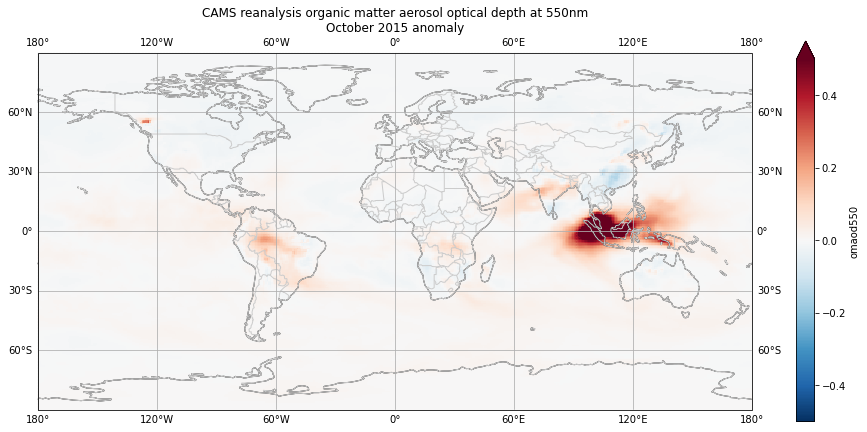

In [8]:
import matplotlib.pyplot as plt

import cartopy
import cartopy.crs as ccrs

map_proj = ccrs.PlateCarree()
BORDER_COLOUR = "#cccccc"

f, ax = plt.subplots(figsize=(16, 7), subplot_kw=dict(projection=map_proj))

anomaly = this_year - clim
p = anomaly.omaod550.plot(ax=ax, transform=ccrs.PlateCarree(), cmap="RdBu_r", vmin=-0.5, vmax=0.5)
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, color=BORDER_COLOUR)
ax.coastlines(color=BORDER_COLOUR)
# ax.set_extent((55, 170, -50, 50))
ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree() )
plt.title("CAMS reanalysis organic matter aerosol optical depth at 550nm\nOctober 2015 anomaly")
plt.show()